In [1]:
import pandas as pd

from significance_analysis import conduct_analysis

# Load example dataset
data = pd.read_csv("./example_dataset.csv")

P-value: 0.9875498913332933

As the p-value 0.9875498913332933 is not smaller than 0.05, we cannot reject the Null-Hypothesis that the model that does not consider the acquisition and the budget describes the data as well as the one that does. Therefore there is no significant difference within acquisition and budget
.
P-values adjusted by tukey method for family of 36 estimates
                  acquisition budget_bins  Estimate  2.5_ci  97.5_ci     SE     DF
1         ExpectedImprovement          11     8.249 -12.117   28.615  6.401  3.001
2    ProbabilityOfImprovement          11     8.351 -12.015   28.718  6.401  3.001
3        UpperConfidenceBound          11     8.231 -12.135   28.598  6.401  3.001
4        qExpectedImprovement          11     8.350 -12.017   28.716  6.401  3.001
5          qKnowledgeGradient          11     8.506 -11.860   28.872  6.401  3.001
6   qProbabilityOfImprovement          11     8.736 -11.630   29.102  6.401  3.001
7               qSimpleRegret        

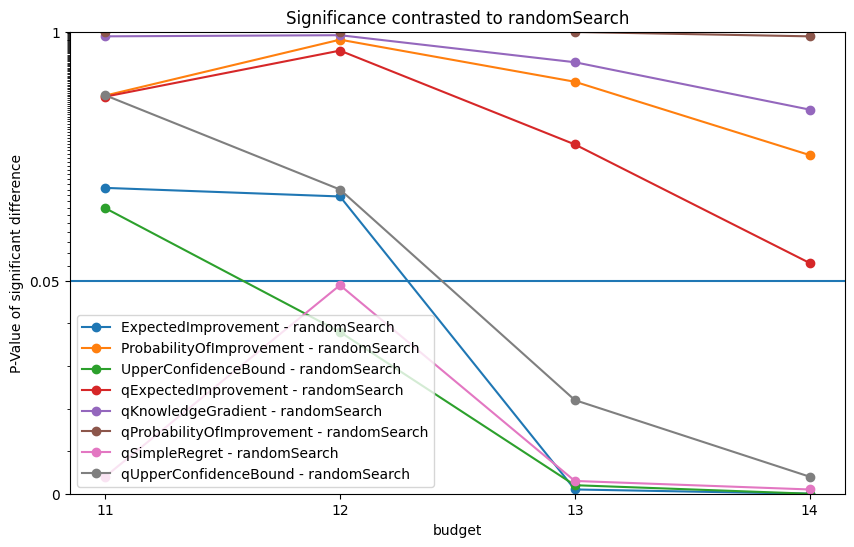

({'chi_square': 11.195269602161716, 'df': 24, 'p': 0.9875498913332933},
 (                  acquisition budget_bins  Estimate  2.5_ci  97.5_ci     SE     DF
  1         ExpectedImprovement          11     8.249 -12.117   28.615  6.401  3.001
  2    ProbabilityOfImprovement          11     8.351 -12.015   28.718  6.401  3.001
  3        UpperConfidenceBound          11     8.231 -12.135   28.598  6.401  3.001
  4        qExpectedImprovement          11     8.350 -12.017   28.716  6.401  3.001
  5          qKnowledgeGradient          11     8.506 -11.860   28.872  6.401  3.001
  6   qProbabilityOfImprovement          11     8.736 -11.630   29.102  6.401  3.001
  7               qSimpleRegret          11     8.044 -12.322   28.410  6.401  3.001
  8       qUpperConfidenceBound          11     8.352 -12.015   28.718  6.401  3.001
  9                randomSearch          11     8.729 -11.638   29.095  6.401  3.001
  10        ExpectedImprovement          12     7.706 -12.655   28.068  6.402 

In [2]:
# Second Analysis: Analyse performance of acquisition functions over all benchmarks binned by trainingrounds,
# i.e. performance in the first 8, the next 12, the next 15, the next 10 and the final 5 rounds.
# Does not print the results, only shows plots.
data2=data.loc[data["benchmark"]!="NN_HPO_Bench"]
data2=data2.loc[(data2["budget"]>10)&(data2["budget"]<16)]
conduct_analysis(
    data2,
    "mean",
    "acquisition",
    "benchmark",
    bin_id="budget",
    bins=[],
    summarize=True,
    show_plots=False,
    significance_plot="randomSearch"
)

In [3]:
import random
data5=data.loc[data["benchmark"]!="NN_HPO_Bench"]
runs=10


def proportion_data(data,runs,minimum=0,stepsize=1):
    data_by_algorithm=[]
    data4=pd.DataFrame(columns=data.columns)
    for algo in data["acquisition"].unique():
        data_by_algorithm.append(data.loc[data["acquisition"]==algo])
        seed_list=list(data_by_algorithm[-1]["seed"].unique())
        for seed in seed_list:
            if len(data.loc[data["seed"]==seed]["seed"])!=50:
                seed_list.remove(seed)
        if minimum==0:
            selected_seeds=random.sample(seed_list,runs)
            for seed in selected_seeds:
                data4=pd.concat([data4,data_by_algorithm[-1].loc[data_by_algorithm[-1]["seed"]==seed]])
            
        else:
            selected_seeds=random.sample(seed_list,minimum-1)
            
            for seed in selected_seeds:
                data4=pd.concat([data4,data_by_algorithm[-1].loc[data_by_algorithm[-1]["seed"]==seed]])
            list_of_datasets=[data4]
            for run in range(minimum,runs,stepsize):
                for step in range(stepsize):
                    selected_seeds.append(next((x for x in seed_list if x not in selected_seeds), None))
                    data4=pd.concat([data4,data_by_algorithm[-1].loc[data_by_algorithm[-1]["seed"].isin([selected_seeds[-1]])]])
                list_of_datasets.append(data4)
    if minimum==0:
        return data4    
    return list_of_datasets

   
#print((proportion_data(data5,10,7,2)))

In [4]:
data3=data.loc[data["benchmark"]!="NN_HPO_Bench"]
result_list=[]
x_data=[]
min_runs=10
max_runs=15
stepsize=5
n_algorithms=len(data3["acquisition"].unique())
for i in range(sum(range(1, n_algorithms))):
    x_data.append([])
for number,dataset in enumerate(proportion_data(data3,max_runs,min_runs,stepsize)):
    print(dataset["benchmark"].value_counts())
    result=conduct_analysis(
        dataset,
        "mean",
        "acquisition",
        "benchmark",
        summarize=False,
        show_plots=False,
    )
    result_list.append(result)
    for algo_combo in range(sum(range(1, n_algorithms))):
        x_data[algo_combo].append(result[1][1]["P-val"][algo_combo])
    print(f"Runs: {number*stepsize+min_runs}")


Branin        3300
Jahs_Bench    1450
Hartmann6     1300
Name: benchmark, dtype: int64
P-value: 0.0005794078925337454

As the p-value 0.0005794078925337454 is smaller than 0.05, we can reject the Null-Hypothesis that the model that does not consider the acquisition describes the data as well as the one that does. Therefore there is significant difference within acquisition.

P-values adjusted by tukey method for family of 36 estimates
The best performing acquisition is ProbabilityOfImprovement, but ['ExpectedImprovement', 'UpperConfidenceBound', 'qExpectedImprovement', 'qKnowledgeGradient', 'qProbabilityOfImprovement', 'qSimpleRegret', 'qUpperConfidenceBound'] are only insignificantly worse.

Runs: 10
Branin        3550
Jahs_Bench    1450
Hartmann6     1300
Name: benchmark, dtype: int64
P-value: 0.002834865400631048

As the p-value 0.002834865400631048 is smaller than 0.05, we can reject the Null-Hypothesis that the model that does not consider the acquisition describes the data as wel

Done


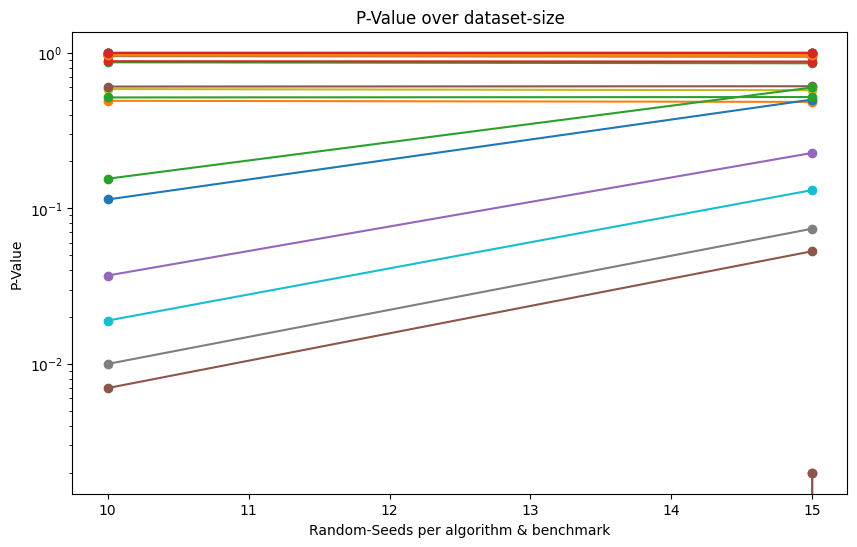

In [5]:
import numpy as np
import matplotlib.pyplot as plt
y_data=np.linspace(min_runs,max_runs,len(x_data[1]))
algo_combo_names=list(result[1][1]["Contrast"].unique())

_, axis = plt.subplots(figsize=(10, 6))
for number,algo_combo in enumerate(x_data):
    axis.errorbar(
        y_data,
        algo_combo,
        label=algo_combo_names[number],
        fmt="o-",
        capsize=3,
        )
print("Done")
axis.set_xlabel("Random-Seeds per algorithm & benchmark")
axis.set_yscale("log")
axis.set_ylabel("P-Value")
axis.set_title(f"P-Value over dataset-size")
#axis.legend()
plt.show()